<a href="https://colab.research.google.com/github/stwind/gan-experiments/blob/master/notebooks/wgan_gp_toy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import math

import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from fastprogress.fastprogress import progress_bar
from sklearn.datasets import make_swiss_roll
from matplotlib.gridspec import GridSpec

sns.set('notebook', 'whitegrid', rc={
    'font.family': ['DejaVu Sans'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 6),
    'grid.linewidth': 1,
    'grid.alpha': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 13,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 14,
})
plt.style.use("dark_background")

print("versions:")
print("numpy: {}".format(np.__version__))
print("seaborn: {}".format(sns.__version__))
print("matplotlib: {}".format(mpl.__version__))
print("pytorch: {}".format(torch.__version__))
for i in range(torch.cuda.device_count()):
    print("cuda device #{}: {}".format(i, torch.cuda.get_device_name(i)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("current device type: {}".format(device.type))

versions:
numpy: 1.19.4
seaborn: 0.11.0
matplotlib: 3.2.2
pytorch: 1.7.0+cu101
cuda device #0: Tesla P100-PCIE-16GB
current device type: cuda


## Datasets

In [2]:
def make_radial_points(n=8, radius=2):
    points = np.zeros((n, 2), dtype=np.float32)
    for i in range(n):
        a = 2 * np.pi / n * i
        points[i,:] = math.cos(a) * radius, math.sin(a) * radius
    return points

def make_grid_points(h, w):
    n = h * w
    points = np.zeros((n, 2), dtype=np.float32)
    i = 0
    for r in range(-(h//2),h//2+1):
        for c in range(-(w//2),w//2+1):
            points[i,:] = r, c
            i += 1
    return points

class GaussianMixture(Dataset):
    def __init__(self, centers, size=64, std=0.02):
        points = []
        for _ in range(size):
            point = np.random.randn(2).astype(np.float32) * std
            i = np.random.choice(len(centers));
            points.append(point + centers[i])
        points = np.array(points)
        points /= points.std()
        self.data = points
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
class SwissRoll(Dataset):
    def __init__(self, size=100, noise=0.05):
        self.data = make_swiss_roll(size, noise=noise)[0][:, [0,2]].astype(np.float32)
        self.data /= self.data.std()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

## Models

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.zeros_(m.bias)

class Generator(nn.Module):
    def __init__(self, nz, nc, ngf=512):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(nz, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, ngf),
            nn.ReLU(True),
            nn.Linear(ngf, nc),
        )

    def forward(self, noise):
        return self.main(noise)

class Discriminator(nn.Module):

    def __init__(self, nc, ndf=512):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(nc, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, ndf),
            nn.ReLU(True),
            nn.Linear(ndf, 1),
        )

    def forward(self, inputs):
        return self.main(inputs)

In [4]:
def compute_gradient_penalty(netD, real, fake, center=0.):
    alpha = torch.rand(real.size(0), 1, device=real.device).expand(real.size())
    interpolates = (alpha * real + (1 - alpha) * fake)
    outputs = netD(interpolates)

    gradients = torch.autograd.grad(outputs=outputs, inputs=interpolates,
                                    grad_outputs=torch.ones_like(outputs, device=real.device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]

    return (gradients.norm(2, dim=1) - center).square().mean()

class WGANTrainer(object):
    def __init__(self, dataloader, netD, netG, nz, device=device,
                 epoch_start=0, epoch_end=1000, n_critics=5, gp_lambda=1,
                 lr_d=1e-4, betas_d=(0.5, 0.9), 
                 lr_g=1e-4, betas_g=(0.5, 0.9)):
        self.dataloader = dataloader
        self.netG = netG
        self.netD = netD
        self.device = device
        self.nz = nz
        self.epoch_start = epoch_start
        self.epoch_end = epoch_end
        self.n_critics = 5
        self.gp_lambda = 1
        self.optimizerD = torch.optim.Adam(netD.parameters(), lr=1e-4, betas=betas_d)
        self.optimizerG = torch.optim.Adam(netG.parameters(), lr=1e-4, betas=betas_g)
        
        self.G_losses = []
        self.D_losses = []
        self.grad_penalties = []
        self.wd_losses = []
        self.crit_reals = []
        self.crit_fakes = []
        self.disc_maps = []
        
        rang = torch.linspace(-3, 3, 100)
        self.grid = torch.dstack(torch.meshgrid(rang, rang)).to(device)
        
    def train(self):
        for epoch in progress_bar(range(self.epoch_start, self.epoch_end)):
            for i, data in enumerate(self.dataloader):
                self.optimizerD.zero_grad()

                data_real = data.to(device)
                d_real = self.netD(data_real).mean()

                z = torch.randn(data_real.size(0), self.nz, device=self.device)
                data_fake = self.netG(z)
                d_fake = self.netD(data_fake).mean()

                gradient_penalty = compute_gradient_penalty(netD, data_real, data_fake) * self.gp_lambda

                d_loss = d_fake - d_real + gradient_penalty
                d_loss.backward()

                self.optimizerD.step()

                if i % self.n_critics == 0:
                    self.wd_losses.append(d_real - d_fake)

                    self.optimizerG.zero_grad()

                    data_fake = self.netG(z)
                    d_fake = self.netD(data_fake).mean()
                    g_loss = -d_fake
                    g_loss.backward()

                    self.optimizerG.step()

                    self.G_losses.append(g_loss.item())
                    self.D_losses.append(d_loss.item())
                    self.grad_penalties.append(gradient_penalty.item())
                    self.crit_reals.append(d_real.item())
                    self.crit_fakes.append(d_fake.item())

            if epoch % 100 == 0:
                print("[{:>3}/{:>4}][{:>2}/{:>2}] D_Loss: {:.4f} G_Loss: {:.4f} CR: {:.4f} CF: {:.4f} GP: {:.4f}".format(
                    epoch, self.epoch_end, i, len(self.dataloader),
                    self.D_losses[-1], self.G_losses[-1], 
                    self.crit_reals[-1], self.crit_fakes[-1],
                    self.grad_penalties[-1]
                ))
                with torch.no_grad():
                    size = len(self.grid)
                    disc_map = netD(self.grid.view(-1,2)).cpu().view(size,size).numpy()
                self.disc_maps.append(disc_map)
    
    def plot_result(self):
        fig = plt.figure(figsize=(14, 10))

        gs = GridSpec(3, 5, height_ratios=[1.8,1,1])

        ax = plt.subplot(gs[0, :2])
        for p in self.dataloader:
            ax.scatter(p[:,0],p[:,1],alpha=0.7,edgecolor='k')
        ax.set_aspect('equal', 'box')
        sns.despine()

        ax = plt.subplot(gs[0, 2:])
        ax.plot(self.G_losses, label="G Loss", alpha=0.8)
        ax.plot(self.D_losses, label="D Loss", alpha=0.8)
        ax.plot(self.grad_penalties, label="Grad Penalty", alpha=0.8)
        ax.plot(self.crit_reals, label="Crit Real", alpha=0.8)
        ax.plot(self.crit_fakes, label="Crit Fake", alpha=0.8)
        ax.plot(self.wd_losses, label="Wasserstein Dist", alpha=0.8)
        ax.set(xlabel="Time", ylabel="Score", title="Training Process")
        ax.legend()

        data_real = next(iter(self.dataloader))
        with torch.no_grad():
            z = torch.randn(data_real.size(0), nz, device=device)
            data_fake = self.netG(z).cpu()

        grid = self.grid.cpu()
        for i, dm in enumerate(self.disc_maps):
            r, c = divmod(i, 5)
            ax = plt.subplot(gs[1+r, c])
            cf = ax.contourf(grid[:,:,0], grid[:,:,1], dm, 10, alpha=0.9, cmap='viridis')
            ax.scatter(data_real[:, 0], data_real[:, 1], c='tab:blue', marker='.', alpha=0.8)
            ax.scatter(data_fake[:, 0], data_fake[:, 1], c='tab:red', marker='x', alpha=0.5)
            ax.set_aspect('equal', 'box')
            ax.set_title("epoch: {}".format(i * 100), fontdict={'fontsize': 11})

        plt.tight_layout()
        plt.show()

## Gaussian 8

In [5]:
batch_size = 64
nz = 100
nc = 2
ngf = 512
ndf = 512

dataloader = DataLoader(GaussianMixture(make_radial_points(), batch_size * 10), batch_size=batch_size, shuffle=True)

print("Generator")
netG = Generator(nz, nc, ngf).to(device)
netG.apply(weights_init)
summary(netG, (nz,))

print("Discriminator")
netD = Discriminator(nc, ndf).to(device)
netD.apply(weights_init)
summary(netD, (nc,))

Generator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          51,712
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
              ReLU-6                  [-1, 512]               0
            Linear-7                    [-1, 2]           1,026
Total params: 578,050
Trainable params: 578,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.21
Estimated Total Size (MB): 2.23
----------------------------------------------------------------
Discriminator
----------------------------------------------------------------
        Layer (ty

In [6]:
trainer = WGANTrainer(dataloader, netD, netG, nz)
trainer.train()

[  0/1000][ 9/10] D_Loss: -0.0108 G_Loss: 0.0010 CR: 0.0100 CF: -0.0010 GP: 0.0001
[100/1000][ 9/10] D_Loss: -0.0145 G_Loss: 0.1503 CR: -0.1149 CF: -0.1503 GP: 0.0080
[200/1000][ 9/10] D_Loss: -0.0544 G_Loss: 0.4600 CR: -0.3605 CF: -0.4600 GP: 0.0470
[300/1000][ 9/10] D_Loss: -0.0595 G_Loss: 0.4399 CR: -0.3056 CF: -0.4399 GP: 0.0590
[400/1000][ 9/10] D_Loss: -0.0530 G_Loss: 0.2725 CR: -0.1747 CF: -0.2725 GP: 0.0446
[500/1000][ 9/10] D_Loss: -0.0307 G_Loss: 0.1166 CR: -0.0593 CF: -0.1166 GP: 0.0358
[600/1000][ 9/10] D_Loss: -0.0367 G_Loss: 0.0002 CR: 0.0637 CF: -0.0002 GP: 0.0339
[700/1000][ 9/10] D_Loss: -0.0258 G_Loss: -0.0007 CR: 0.0560 CF: 0.0007 GP: 0.0228
[800/1000][ 9/10] D_Loss: -0.0145 G_Loss: -0.0253 CR: 0.0640 CF: 0.0253 GP: 0.0184
[900/1000][ 9/10] D_Loss: -0.0093 G_Loss: 0.0051 CR: 0.0170 CF: -0.0051 GP: 0.0125


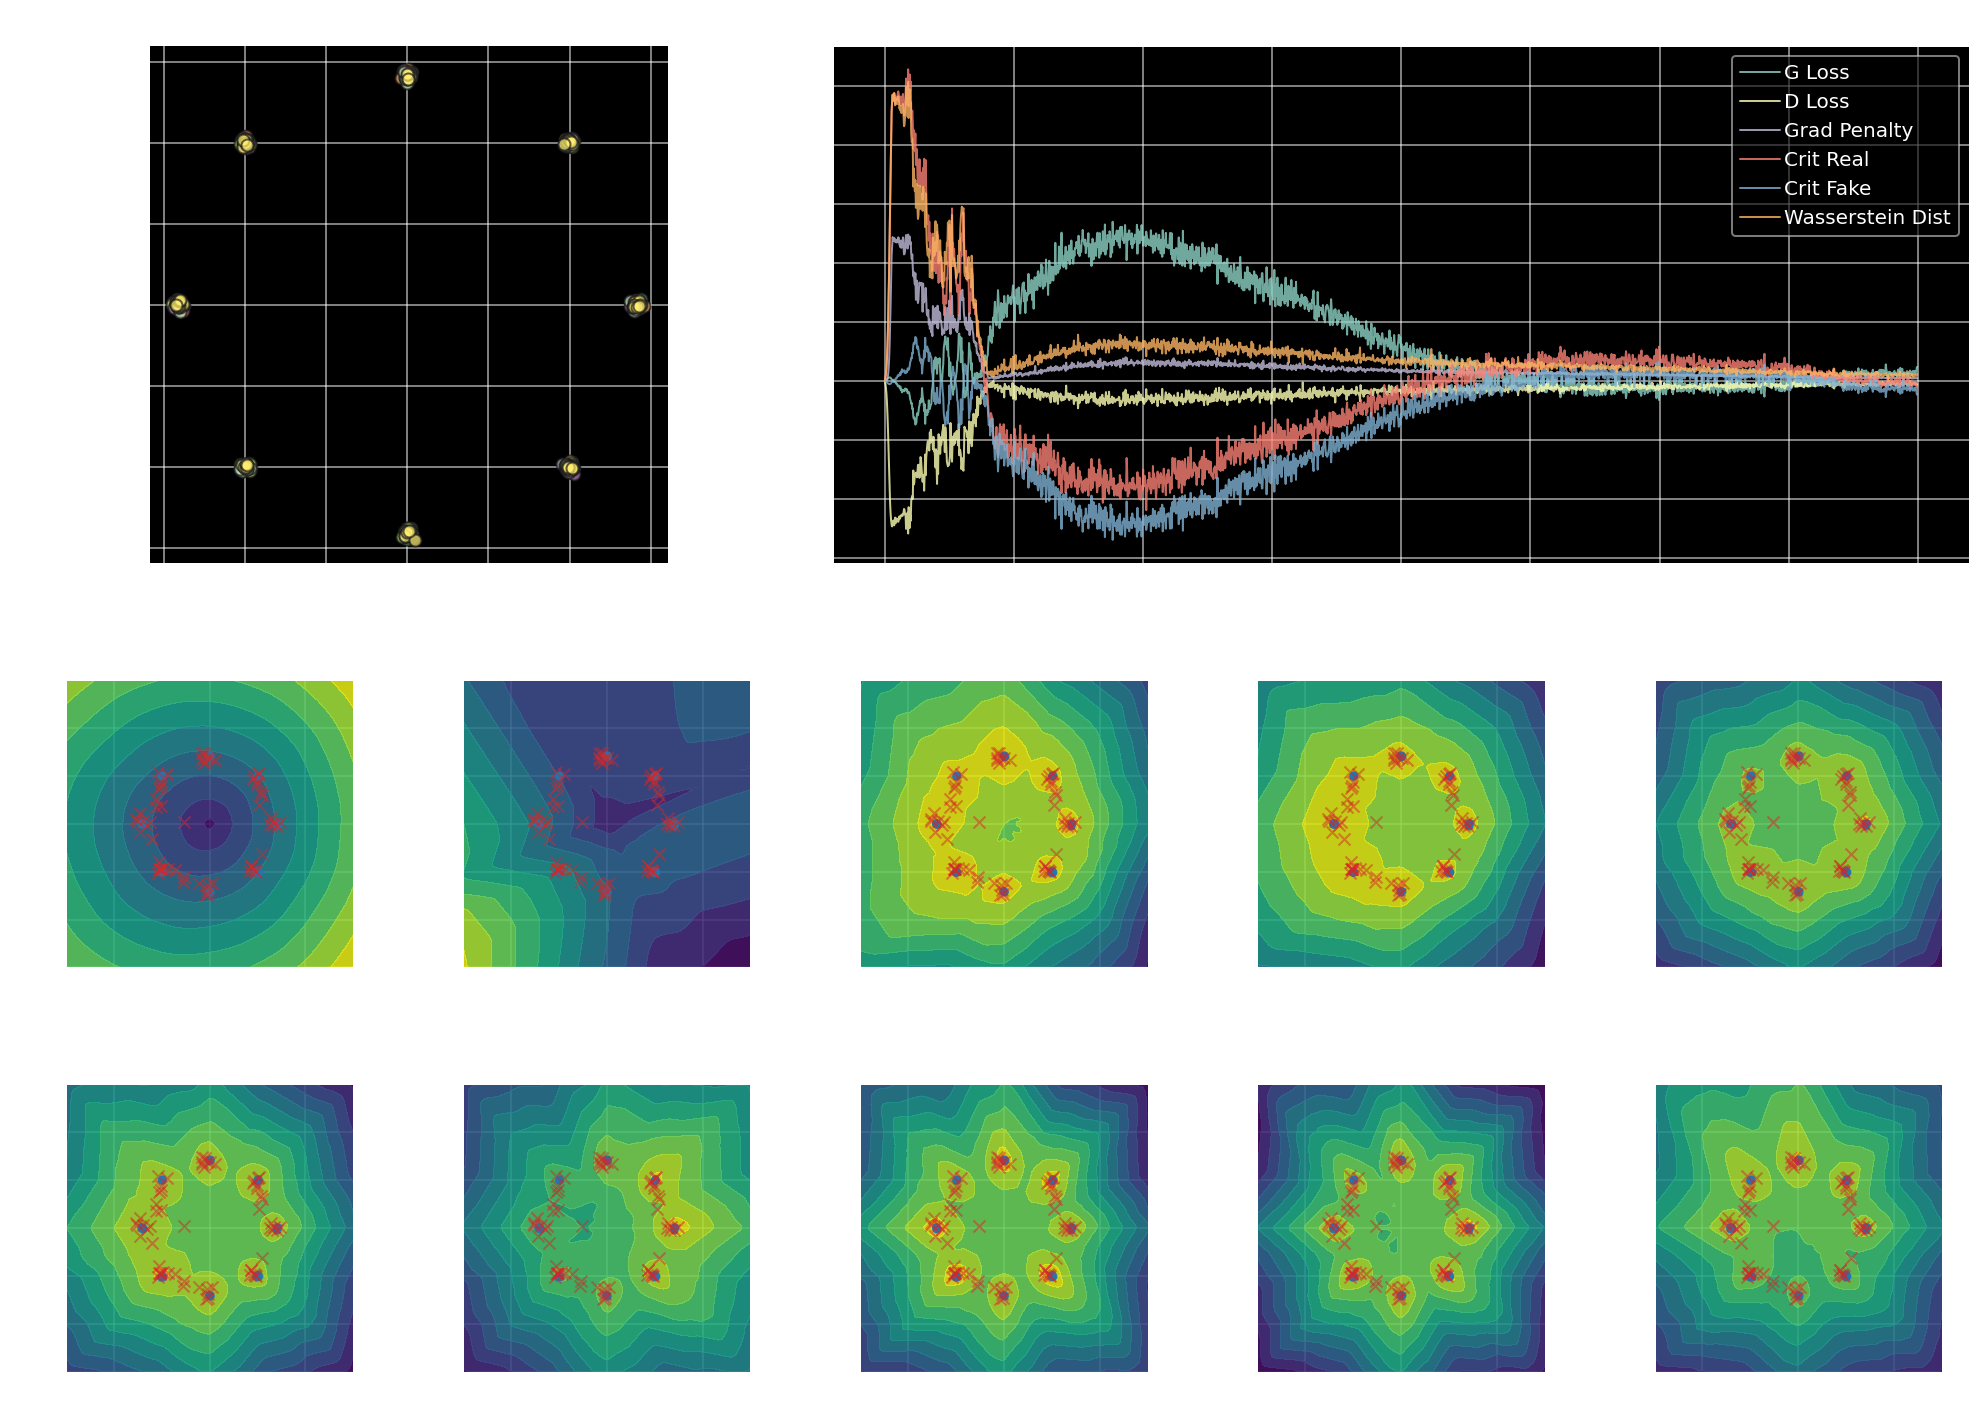

In [7]:
trainer.plot_result()

## Gaussian 25

In [8]:
batch_size = 64
nz = 100
nc = 2
ngf = 512
ndf = 512

dataloader = DataLoader(GaussianMixture(make_grid_points(5, 5), batch_size * 10), batch_size=batch_size, shuffle=True)

print("Generator")
netG = Generator(nz, nc, ngf).to(device)
netG.apply(weights_init)
summary(netG, (nz,))

print("Discriminator")
netD = Discriminator(nc, ndf).to(device)
netD.apply(weights_init)
summary(netD, (nc,))

Generator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          51,712
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
              ReLU-6                  [-1, 512]               0
            Linear-7                    [-1, 2]           1,026
Total params: 578,050
Trainable params: 578,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.21
Estimated Total Size (MB): 2.23
----------------------------------------------------------------
Discriminator
----------------------------------------------------------------
        Layer (ty

In [9]:
trainer = WGANTrainer(dataloader, netD, netG, nz)
trainer.train()

[  0/1000][ 9/10] D_Loss: -0.0088 G_Loss: 0.0012 CR: 0.0079 CF: -0.0012 GP: 0.0001
[100/1000][ 9/10] D_Loss: -0.0025 G_Loss: 0.0907 CR: -0.0876 CF: -0.0907 GP: 0.0038
[200/1000][ 9/10] D_Loss: -0.0183 G_Loss: 0.2605 CR: -0.2292 CF: -0.2605 GP: 0.0081
[300/1000][ 9/10] D_Loss: -0.0269 G_Loss: 0.4727 CR: -0.4270 CF: -0.4727 GP: 0.0124
[400/1000][ 9/10] D_Loss: -0.0112 G_Loss: 0.3618 CR: -0.3406 CF: -0.3618 GP: 0.0098
[500/1000][ 9/10] D_Loss: -0.0304 G_Loss: 0.3324 CR: -0.2865 CF: -0.3324 GP: 0.0158
[600/1000][ 9/10] D_Loss: -0.0119 G_Loss: 0.3492 CR: -0.3184 CF: -0.3492 GP: 0.0070
[700/1000][ 9/10] D_Loss: -0.0088 G_Loss: 0.3704 CR: -0.3452 CF: -0.3704 GP: 0.0132
[800/1000][ 9/10] D_Loss: -0.0324 G_Loss: 0.3592 CR: -0.3105 CF: -0.3592 GP: 0.0122
[900/1000][ 9/10] D_Loss: -0.0201 G_Loss: 0.3220 CR: -0.2882 CF: -0.3220 GP: 0.0135


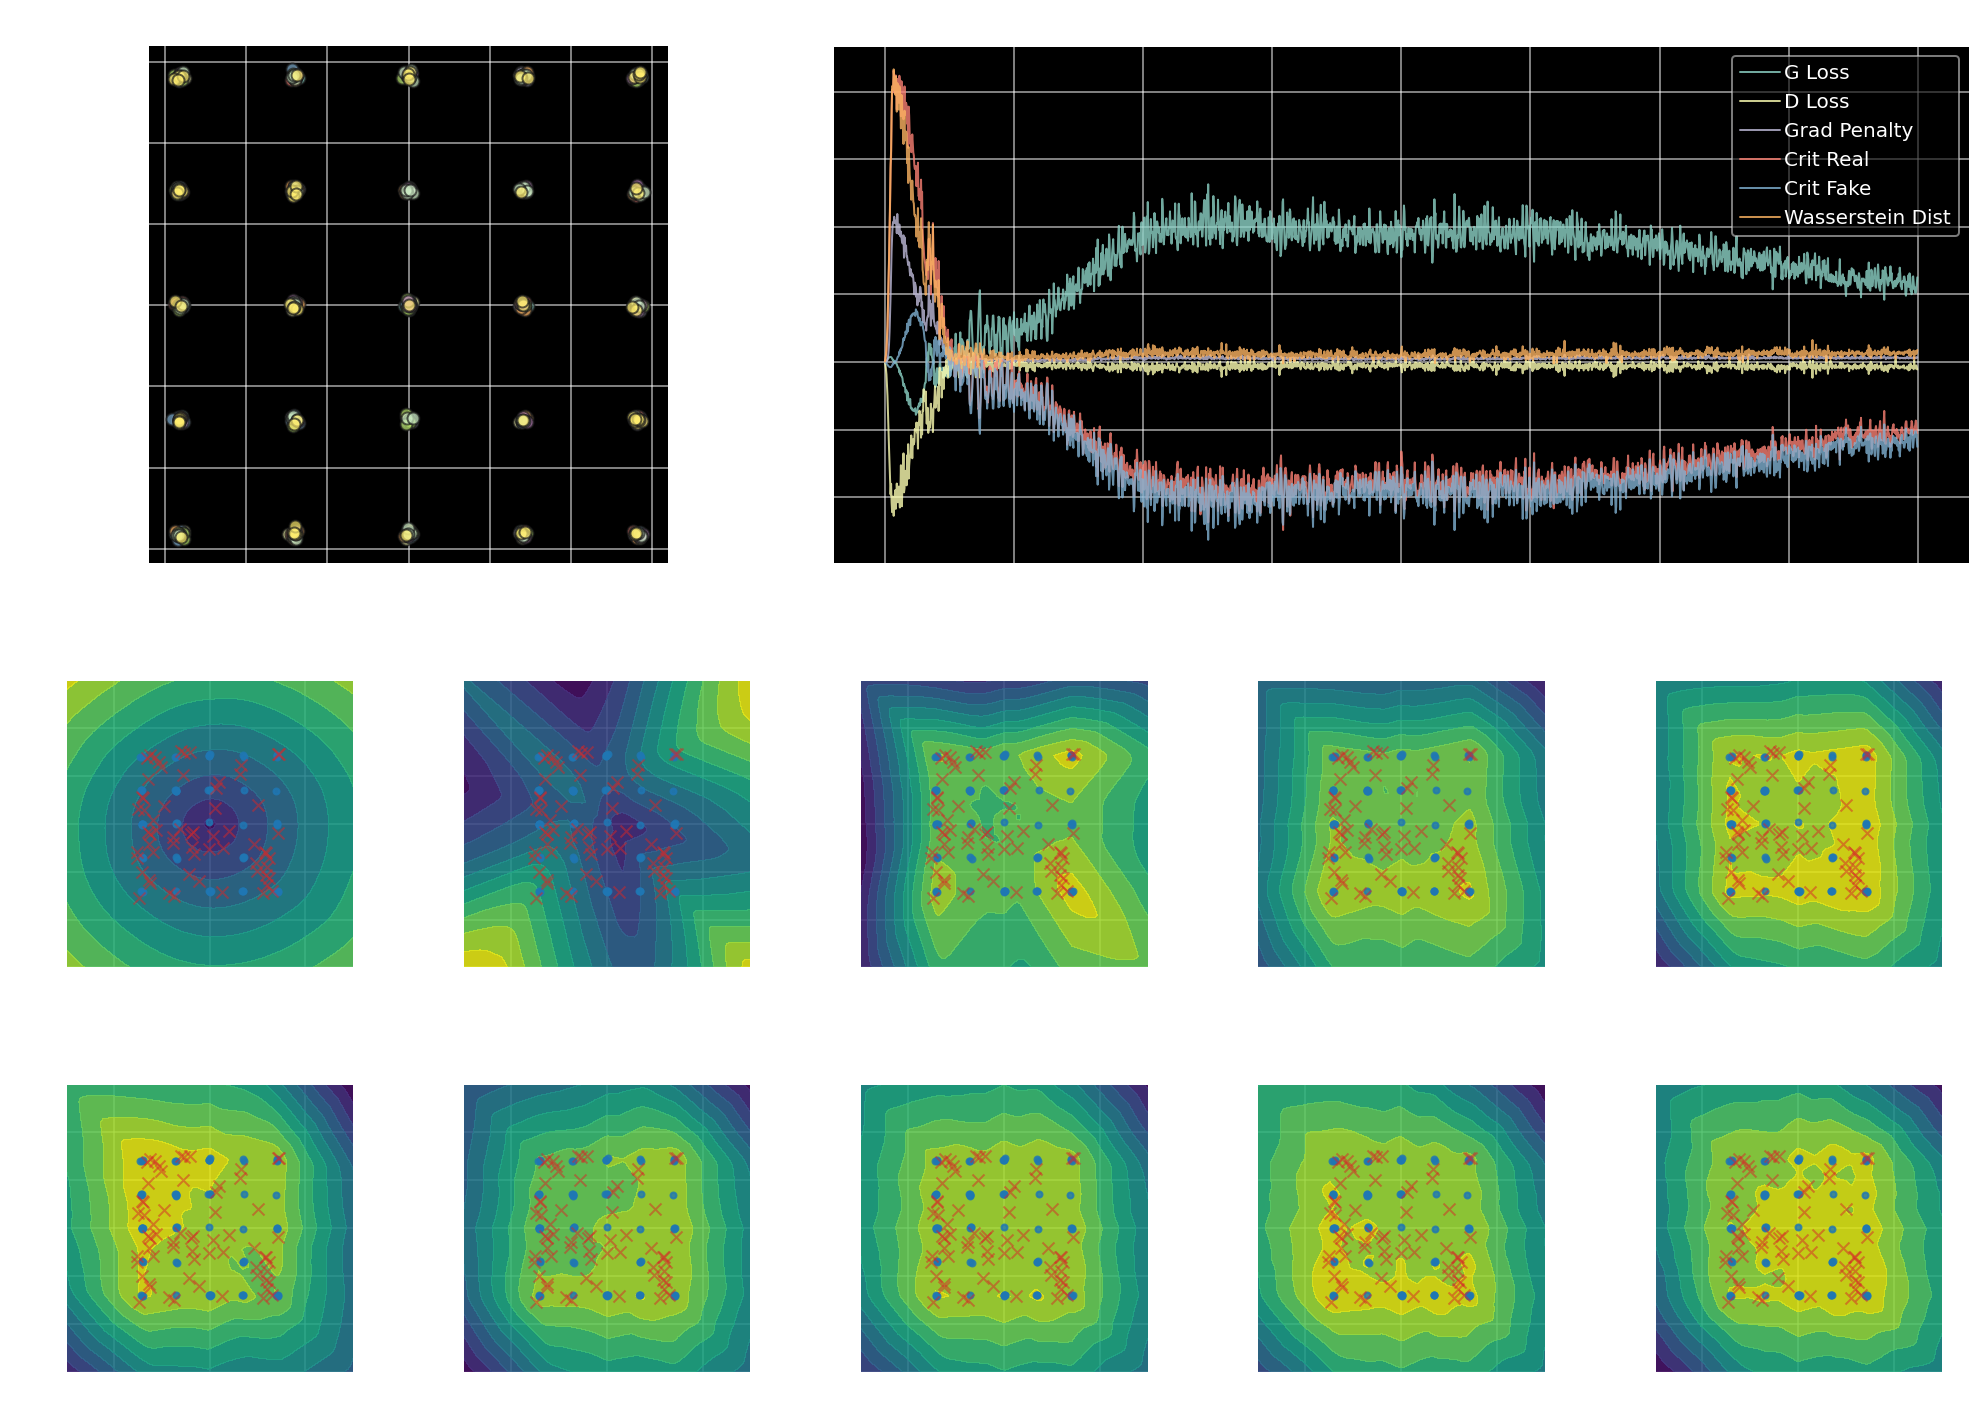

In [10]:
trainer.plot_result()

## Swiss Roll

In [11]:
batch_size = 64
nz = 100
nc = 2
ngf = 512
ndf = 512

dataloader = DataLoader(SwissRoll(batch_size * 10), batch_size=batch_size, shuffle=True)

print("Generator")
netG = Generator(nz, nc, ngf).to(device)
netG.apply(weights_init)
summary(netG, (nz,))

print("Discriminator")
netD = Discriminator(nc, ndf).to(device)
netD.apply(weights_init)
summary(netD, (nc,))

Generator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          51,712
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
              ReLU-6                  [-1, 512]               0
            Linear-7                    [-1, 2]           1,026
Total params: 578,050
Trainable params: 578,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.21
Estimated Total Size (MB): 2.23
----------------------------------------------------------------
Discriminator
----------------------------------------------------------------
        Layer (ty

In [12]:
trainer = WGANTrainer(dataloader, netD, netG, nz)
trainer.train()

[  0/1000][ 9/10] D_Loss: -0.0108 G_Loss: 0.0007 CR: 0.0103 CF: -0.0007 GP: 0.0001
[100/1000][ 9/10] D_Loss: -0.0073 G_Loss: 0.0947 CR: -0.0860 CF: -0.0947 GP: 0.0111
[200/1000][ 9/10] D_Loss: -0.0280 G_Loss: 0.1787 CR: -0.1396 CF: -0.1787 GP: 0.0118
[300/1000][ 9/10] D_Loss: -0.0301 G_Loss: 0.0867 CR: -0.0282 CF: -0.0867 GP: 0.0179
[400/1000][ 9/10] D_Loss: -0.0293 G_Loss: 0.0197 CR: 0.0290 CF: -0.0197 GP: 0.0239
[500/1000][ 9/10] D_Loss: -0.0172 G_Loss: 0.0627 CR: -0.0251 CF: -0.0627 GP: 0.0205
[600/1000][ 9/10] D_Loss: -0.0094 G_Loss: 0.0370 CR: -0.0093 CF: -0.0370 GP: 0.0193
[700/1000][ 9/10] D_Loss: -0.0234 G_Loss: 0.0830 CR: -0.0423 CF: -0.0830 GP: 0.0138
[800/1000][ 9/10] D_Loss: -0.0225 G_Loss: 0.0809 CR: -0.0390 CF: -0.0809 GP: 0.0134
[900/1000][ 9/10] D_Loss: -0.0215 G_Loss: 0.0654 CR: -0.0292 CF: -0.0654 GP: 0.0139


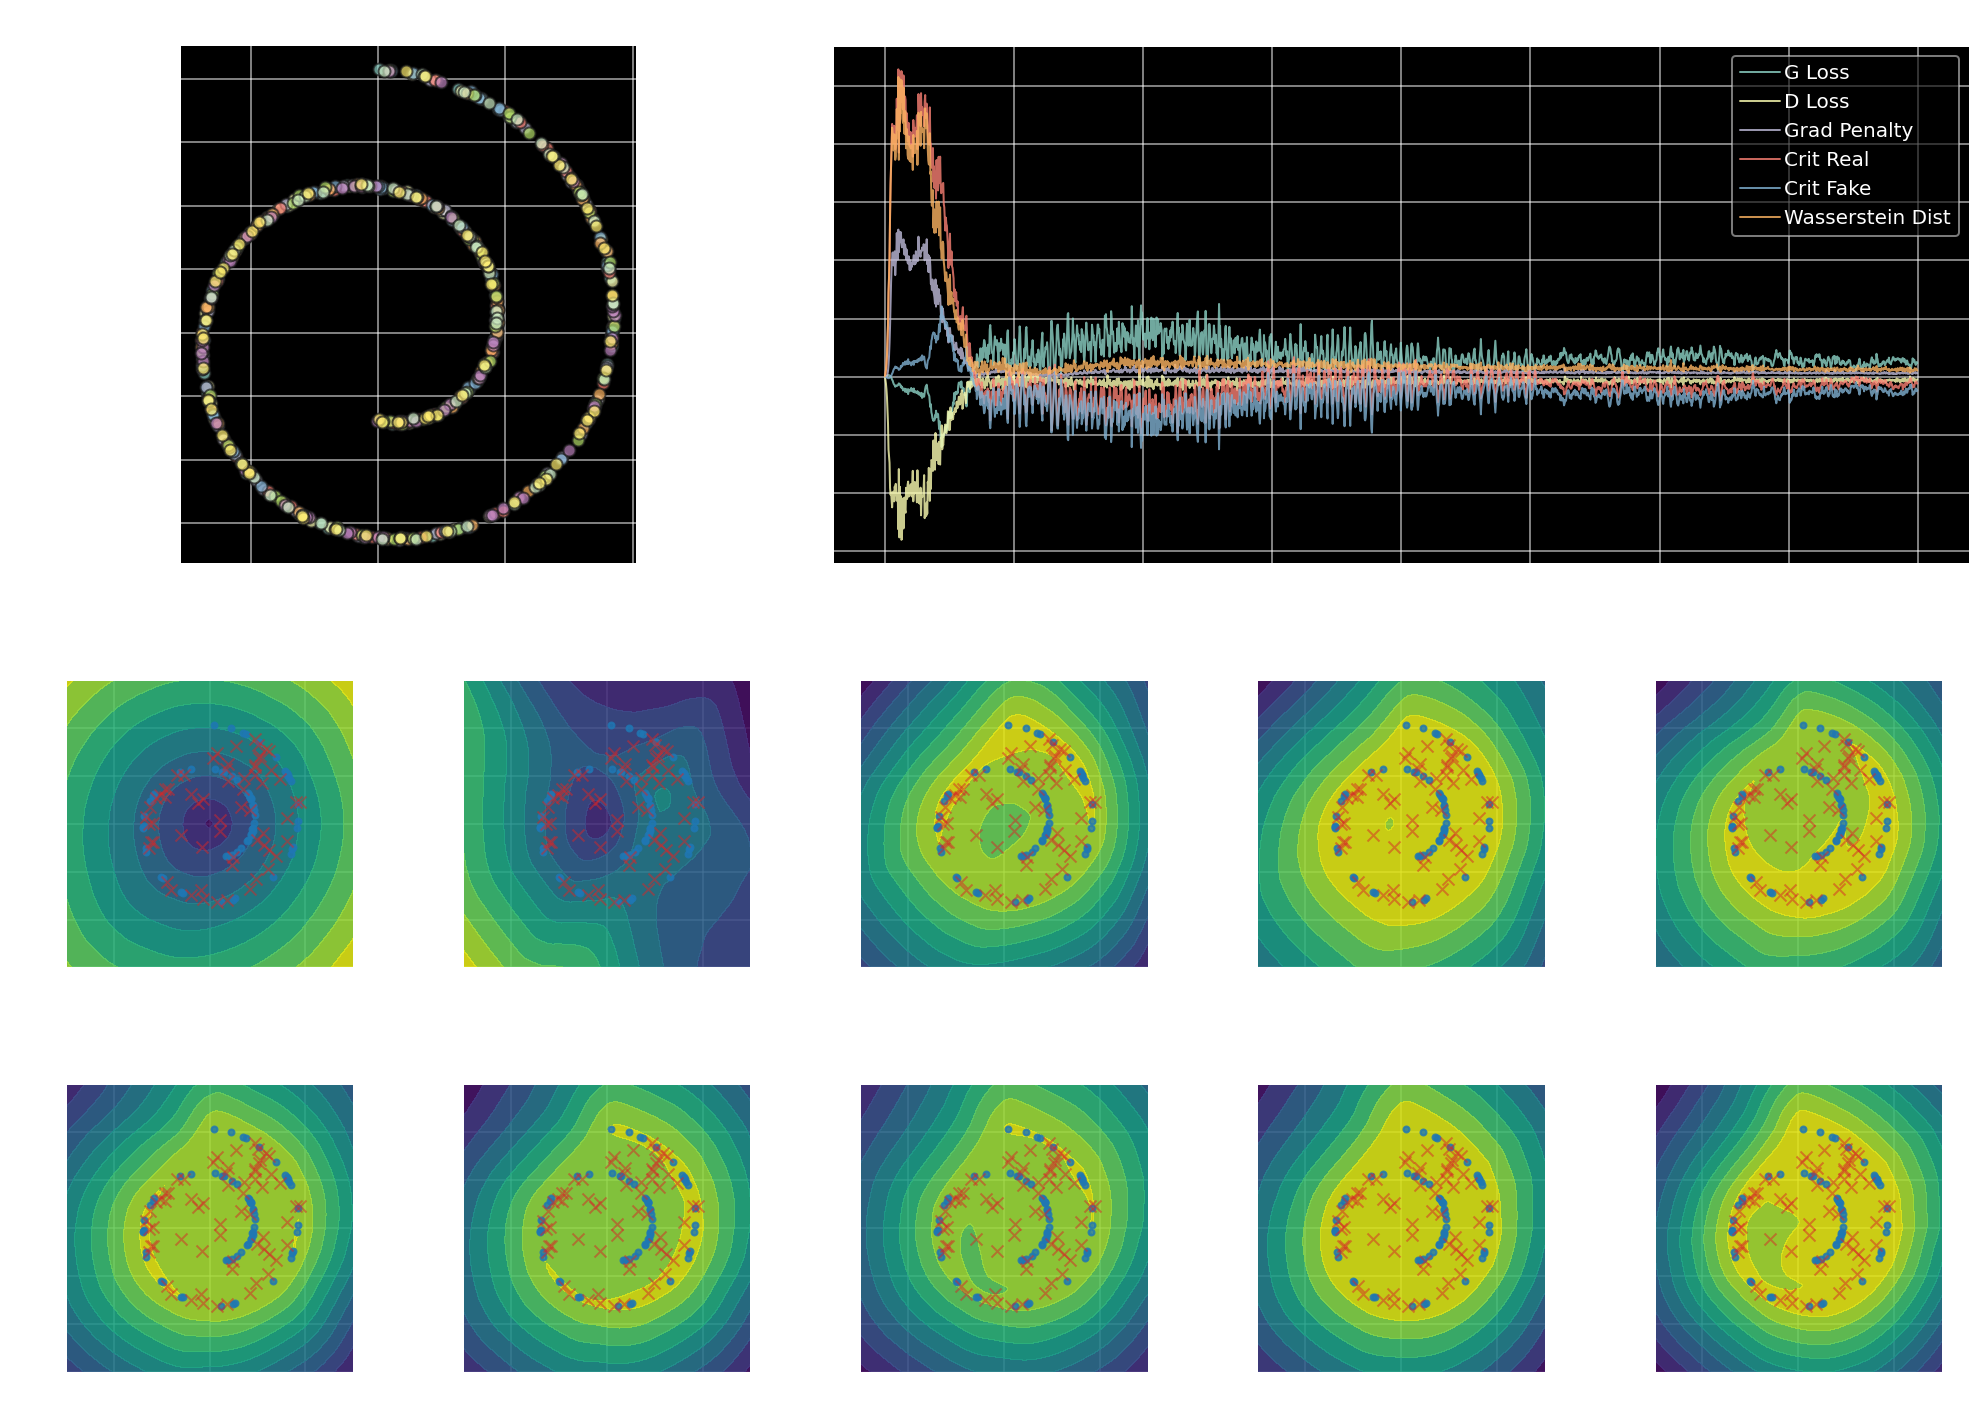

In [13]:
trainer.plot_result()